In [35]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA

In [36]:
df = pd.read_excel("Indicadores.xlsx")

In [37]:
# Dividirlo por periodo
df['Periodo'] = pd.to_datetime(df['Periodo'])

In [38]:
df = df.sort_values(by="Periodo")

In [39]:
df = df.set_index("Periodo")

In [40]:
df

,Valor
Periodo,
1993-01-01,60.407691
1993-02-01,61.022521
1993-03-01,63.943249
1993-04-01,61.865984
1993-05-01,63.612900
...,...
2022-03-01,111.940152
2022-04-01,109.529866
2022-05-01,114.442424


<AxesSubplot:xlabel='Periodo'>

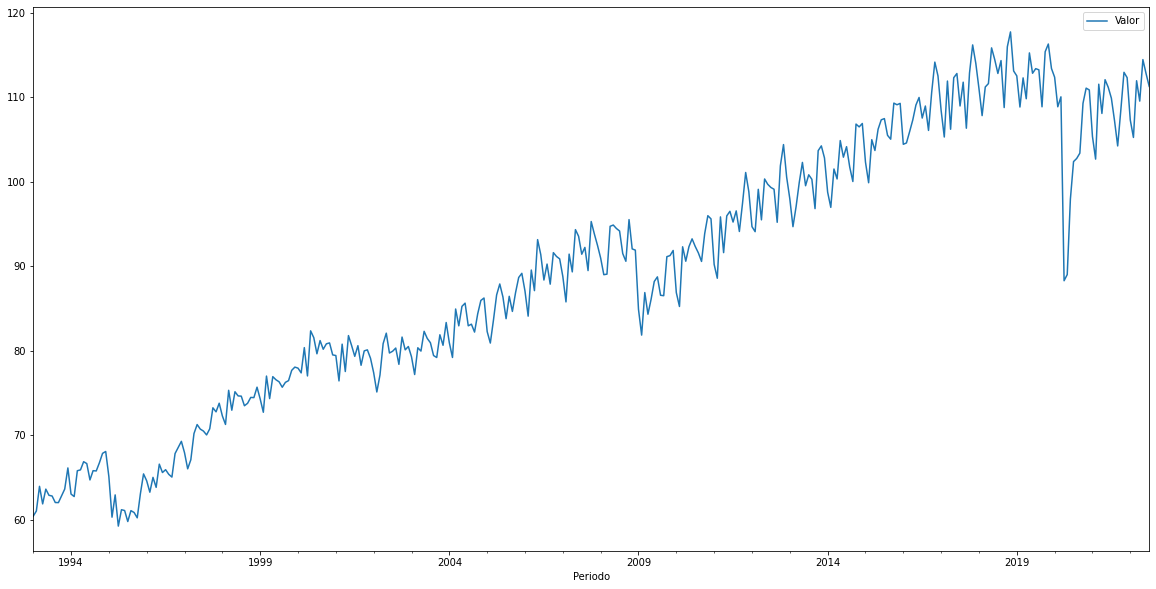

In [41]:
df.plot(figsize=(20,10))

<AxesSubplot:xlabel='Periodo'>

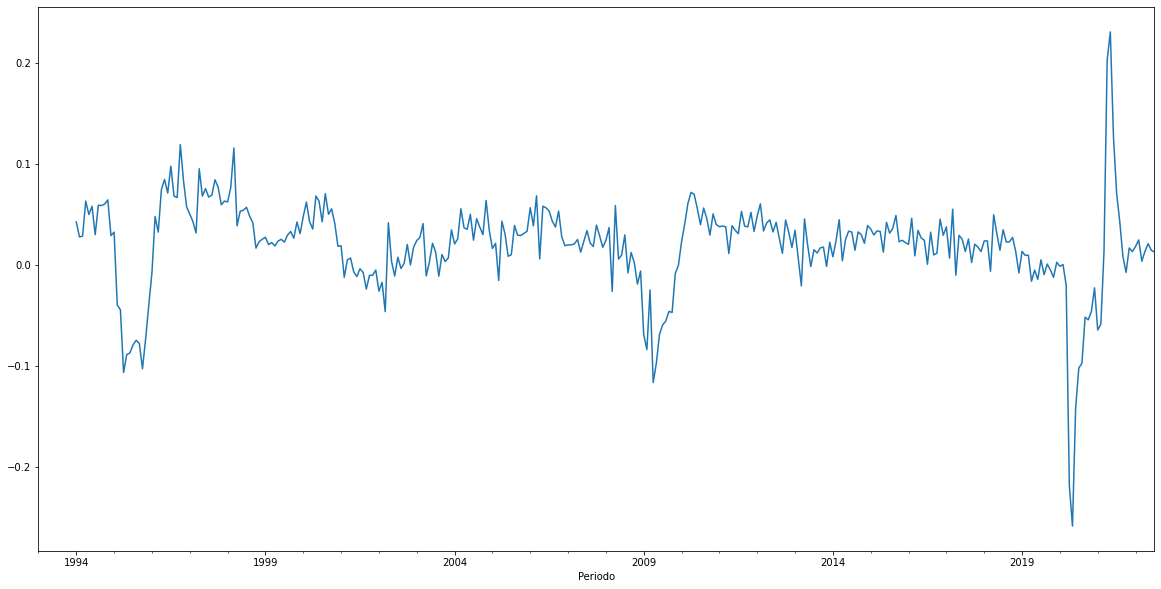

In [42]:
log_plot = np.log(df['Valor']) - np.log(df['Valor']).shift(12) 
log_plot.plot(figsize=(20,10))

Usamos base logaritmica para buscar estacionariedad, pero es difícil analizar la gráfica por la dispersión de los datos, por eso usaremos la prueba de Dicky-Fuller

In [43]:
aux = log_plot.dropna()

# Creamos una función para generar los outputs
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)

# Aplicamos la función para conocer la estacionalidad
df_aux = adf_test(aux)
df_aux

Results of Dickey-Fuller Test:
Test Statistic                  -3.767292
p-value                          0.003260
#Lags Used                      17.000000
Number of Observations Used    325.000000
Critical Value (1%)             -3.450632
Critical Value (5%)             -2.870474
Critical Value (10%)            -2.571530
dtype: float64


Aquí vemos que nuestro p-value es menor a 0.05, esto quiere decir que es estacionaria y listo para aplicar el modelo ARIMA-SARIMA

### Modelo 1

Para el primer modelo usaremos los siguientes parámetros: D = 1, d = 0, ya que trabajamos con serie estacionaria y vamos a calcular de forma mensual

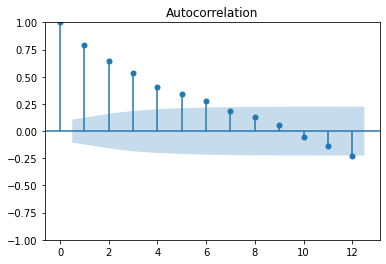

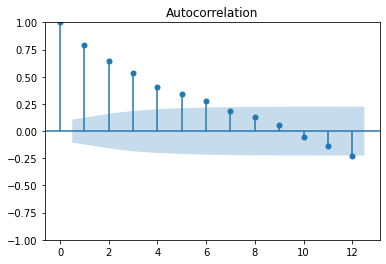

In [45]:
plot_acf(aux, lags=12)

En la gráfica anterior de autocorrelación vemos que hasta el junio (lags 6) tiene una significancia positiva, y se desvanece hasta diciembre (lags 12)

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


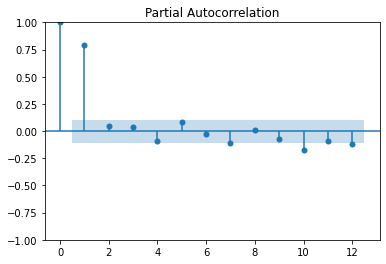

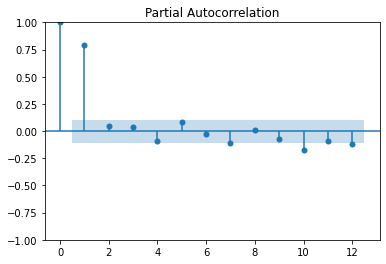

In [46]:
plot_pacf(aux, lags=12)

Y en la gráfica de autocorrelación parcial sólo en los primeros dos meses tienen significancia positiva. Por esta razón, actualizamos nuestros parámetros del modelo con: p = 1, q = 0; ya que sólo hay significancia entre un mes y el proximo.

In [49]:
# Arima(p,d,q)
p = 1
d = 0
q = 0

# Sarima(P,D,Q,12)
P = 0
D = 1
Q = 0

y = np.log(df['Valor'])
mod1 = sm.tsa.statespace.SARIMAX(y, order=(p,d,q), seasonal_order=(P,D,Q,12), trend='c', simple_differencing=True)

model1 = mod1.fit()
model1.summary()

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DS12.Valor   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(0, 0, 0, 12)   Log Likelihood                 741.706
Date:                            Fri, 25 Nov 2022   AIC                          -1477.413
Time:                                    21:59:58   BIC                          -1465.899
Sample:                                01-01-1994   HQIC                         -1472.827
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0041      0.002      2.741      0.006       0.001       0.007
ar.L1          0.7905      0.021     36.847      0.000       0.748       0.833
sigma2         0.0008   2.09e-05     36.988      0.000       0.001       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.42   Jarque-Bera (JB):              3075.60
Prob(Q):                              0.52   Prob(JB):                         0.00
Heteroskedasticity (H):               2.24   Skew:                            -0.44
Prob(H) (two-sided):                  0.00   Kurtosis:                        17.64
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Con el resumen del modelo 1, podemos observar que la economía de México es positiva y es significativa con el mes anterior, y se refleja con un 79.05%.

Ahora usaremos los residuales del modelo 1 para gráficar y analizar la autocorrelación y la autocorrelación parcial, ya que esto podemos mejorar el modelo ajustando parámetros en caso de ser ncesario

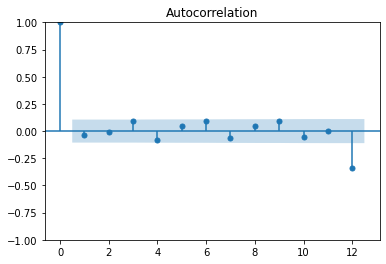

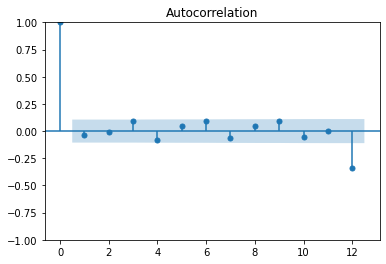

In [50]:
plot_acf(model1.resid, lags=12)

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


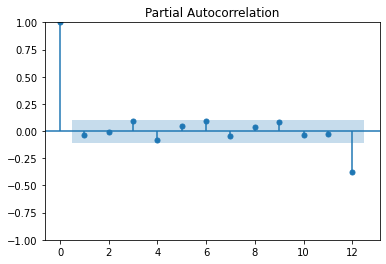

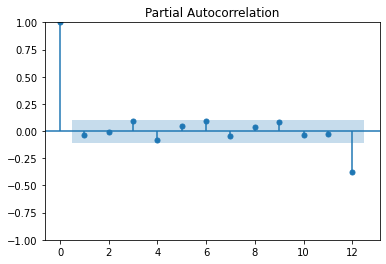

In [51]:
plot_pacf(model1.resid, lags=12)

En las dos gráficas anteriores podemos observar que el último mes tiene autocorrelación con el mes anterior (diciembre con enero), por eso es necesario modificar el parámetro Q en modelo 2 para comprobar si realmente puede mejorar

## Modelo 2

In [59]:
# Arima(p,d,q)
p = 1
d = 0
q = 1

# Sarima(P,D,Q,12)
P = 0
D = 1
Q = 1

y = np.log(df['Valor'])
mod2 = sm.tsa.statespace.SARIMAX(y, order=(p,d,q), seasonal_order=(P,D,Q,12), trend='c', simple_differencing=True)

model2 = mod2.fit()
model2.summary()

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                         DS12.Valor   No. Observations:                  343
Model:             SARIMAX(1, 0, 1)x(0, 0, 1, 12)   Log Likelihood                 809.643
Date:                            Fri, 25 Nov 2022   AIC                          -1609.286
Time:                                    22:17:25   BIC                          -1590.097
Sample:                                01-01-1994   HQIC                         -1601.642
                                     - 07-01-2022                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0016      0.000      3.380      0.001       0.001       0.002
ar.L1          0.9228      0.022     41.956      0.000       0.880       0.966
ma.L1         -0.1946      0.037     -5.287      0.000      -0.267      -0.122
ma.S.L12      -0.8413      0.046    -18.479      0.000      -0.931      -0.752
sigma2         0.0005   1.31e-05     38.123      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   0.08   Jarque-Bera (JB):             10340.00
Prob(Q):                              0.78   Prob(JB):                         0.00
Heteroskedasticity (H):               2.34   Skew:                            -2.73
Prob(H) (two-sided):                  0.00   Kurtosis:                        29.34
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

Ahora vemos que el modelo 2 mejoró bastante a comparación del modelo 1, su significancia es de 87.93% con el mes anterior.

Después, seguimos los mismos pasos para analizar la autocorrelación y la autocorrelación parcial para ver si podemos mejorar.

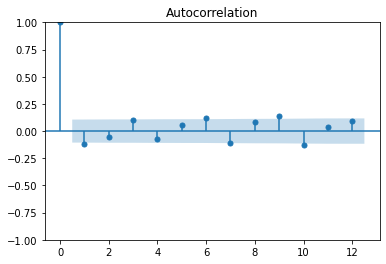

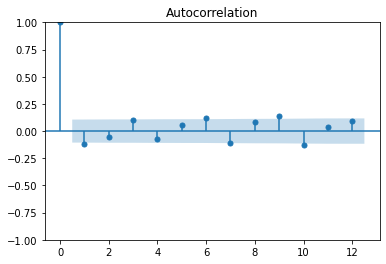

In [56]:
plot_acf(model2.resid, lags=12)

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


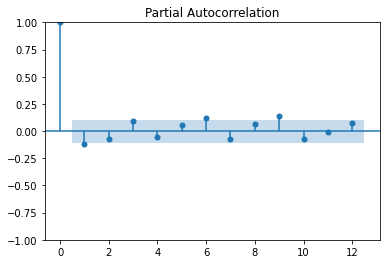

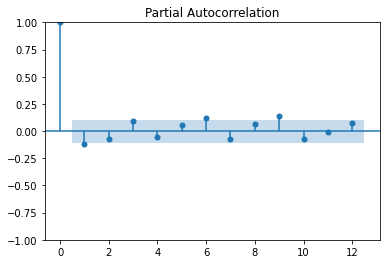

In [57]:
plot_pacf(model2.resid, lags=12)

Después de analizar las gráficas, vemos que el residuo del modelo mejoraron bastante, sin embargo podemos agregar un término más de AR para mejorar aún más el modelo.

## Modelo 3

In [63]:
# Arima(p,d,q)
p = 1
d = 0
q = 0

# Sarima(P,D,Q,12)
P = 1
D = 1
Q = 1

y = np.log(df['Valor'])
mod3 = sm.tsa.statespace.SARIMAX(y, order=(p,d,q), seasonal_order=(P,D,Q,12), trend='c', simple_differencing=True)

model3 = mod3.fit()
model3.summary()

c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
c:\Users\Keyuan\AppData\Local\Programs\Python\Python310\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                                      SARIMAX Results                                       
============================================================================================
Dep. Variable:                           DS12.Valor   No. Observations:                  343
Model:             SARIMAX(1, 0, 0)x(1, 0, [1], 12)   Log Likelihood                 808.567
Date:                              Fri, 25 Nov 2022   AIC                          -1607.134
Time:                                      22:19:56   BIC                          -1587.946
Sample:                                  01-01-1994   HQIC                         -1599.491
                                       - 07-01-2022                                         
Covariance Type:                                opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0023      0.000      6.656      0.000       0.002       0.003
ar.L1          0.8697      0.019     45.272      0.000       0.832       0.907
ar.S.L12       0.1534      0.085      1.811      0.070      -0.013       0.319
ma.S.L12      -0.8897      0.067    -13.256      0.000      -1.021      -0.758
sigma2         0.0005    1.3e-05     38.568      0.000       0.000       0.001
===================================================================================
Ljung-Box (L1) (Q):                   3.36   Jarque-Bera (JB):              8221.81
Prob(Q):                              0.07   Prob(JB):                         0.00
Heteroskedasticity (H):               2.13   Skew:                            -2.34
Prob(H) (two-sided):                  0.00   Kurtosis:                        26.52
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

## Predicción con el modelo 3

In [66]:
y = np.log(df['Valor'])
y_pred = 0.0025 + 0.8793*df['Valor'].shift(1) + 0.1534*df['Valor'].shift(1) - 0.8897*(0.0005/0.8897)
df['Pred'] = y_pred

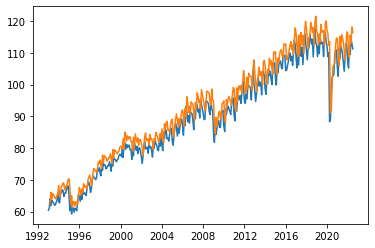

In [67]:
plt.plot(df['Valor'])
plt.plot(df['Pred'])

Aplicando la función obtenida del modelo, podemos observar que la gráfica predice buenos resultados y está por encima de los datos originales